---
title: "Classifying handwritten digits (THE MNIST!)"
toc: true
date: "2023-09-09"
author: "Suchit G"
description: "Understand the fundamental structure of a ML project by building a simple neural network on the MNIST dataset!"
categories:
    - Neural Networks
    - fast.ai
    - ComputerVision
---


## Introduction

From MNIST being the first Machine Learning dataset [I heard about](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=DCyrqxpwpuNR72xJ) to building a model for it, I can surely say Machine Learning is a fascinating subject to study! Building a "model" is more than just getting a model and training it. It involves:
- Getting the data
- Preprocessing the data, i.e., cleaning it, converting it into a format that the model can understand, etc.
- Creating the training, validation, and test (test data is not considered in this case) split
- Training the model
- Fine-tuning hyper-parameters based on the inferences gotten from the accuracy and other metrics over the validation dataset, and then improving the model (not done in this case)

Given above is the rough process of building a Machine Learning project. This project maintains a medium level of abstraction and doesn't entirely utilize high-level functions but doesn't go deep into the low-level implementations either. I aim to maintain an understandable and yet not-so-abstracted level of coding throughout. Let's get started!

::: {.callout-important}
If you are referring to this post as a guide, then you are expected to have the following pre-requisites to fully and deeply understand what's going on:
- Basics of Python
- Importing modules, methods and calling them in Python
- A fundamental idea of how a typical Linear Regression model works (knowledge of simple neural networks recommended but not necessary)
- Willingness and the ability to google and read through documentation ;)
:::

::: {.callout-tip}
## Some useful resources 
- [How does a neural net actually work?](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)
- [fastai MNIST chapter](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)
- [My MNIST (2 digits) notebook](https://github.com/SuchitG04/mnist/blob/main/mnist1.ipynb) (linked again later below)
:::

::: {.callout-tip}
If I have trouble understanding a piece of code written by others, here's what I do:
- Try to speak out loudly and explain the code to myself (rubber ducking).
- Search the official docuementation or stack overflow and understand through examples.
- If the above two approaches don't work, then ask ChatGPT to explain the code to me. This step works no matter what!
:::

In [1]:
# Importing the necessary libraries and modules

from fastai.vision.all import *
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler, random_split
from sklearn.model_selection import train_test_split

matplotlib.rc('image', cmap='Greys')


## 1. Downloading the Dataset

PyTorch's `torchvision` has a module named `datasets` that has some some popular datasets available to download and store it in a directory specified by you. If the dataset already exists, then you just need to give it the path to the dataset and it'll skip downloading it. Click [here](https://pytorch.org/vision/0.8/datasets.html#mnist) to know more.

In [2]:
dset = datasets.MNIST(
    root='/home/suchitg/mnist/dset/', # Creates a folder named 'dset' if it's not already created
    train=True, # Specifies what set of data to download (train or test)
    transform=transforms.Compose( # Applies image transformations
        [transforms.ToTensor(),
         transforms.RandomRotation(degrees=30)
        ]
    ),
    download=True
)

print(dset)
print(dset.data.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/suchitg/mnist/dset/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
torch.Size([60000, 28, 28])


[`torchvision.transforms.RandomRotation`](https://pytorch.org/vision/0.8/transforms.html#transforms-on-pil-image-and-torch-tensor) is used to [augment](https://suchitg04.github.io/blog/posts/data-cleaning/) the image being loaded into a `dataloader` by randomly rotating the images about 30°. The reason for selecting this transform was because different handwritings write different digits at varying angles. So, the transformation accomodates for this nuance.

In [3]:
type(dset)

torchvision.datasets.mnist.MNIST


## 2. Train-Val split and Normalization

Here, we use [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data into training and validation datasets. But what is a validation dataset? When we train the model, we improve it by looking at the loss calculated on training set itself (insert reference). But the accuracy (in this case, how many digits the model gets right) is calculated by inputting the images from the validation dataset into the model. That way, we can know how well the model performs on images that it hasn't seen before. If the validation is significantly higher than the training loss (insert reference), then that indicates a case of [overfitting](https://miro.medium.com/v2/resize:fit:1125/1*_7OPgojau8hkiPUiHoGK_w.png).

It is also worth noting that, here, we create a stratified train-val split. What that means is that the number of images from each class is roughly equal. This ensures that the model will be equally good in classifying all digits.

In [4]:
train_x, valid_x, train_y, valid_y = train_test_split(dset.data, dset.targets, test_size=0.2, stratify=dset.targets)

Let us now see an example of how a digit looks in our dataset.

(<matplotlib.image.AxesImage at 0x7f7dc21e7730>, tensor(2))

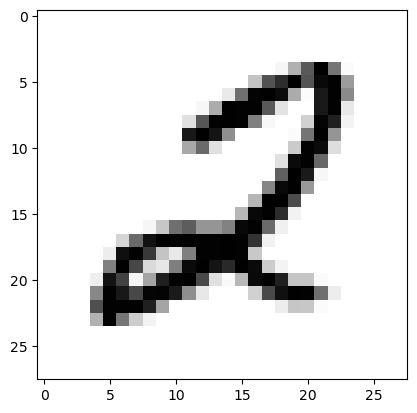

In [5]:
plt.imshow(train_x.numpy()[99]), train_y[99]

Each image `train_x[i]` has pixel values between 0 and 255 as shown below.

In [6]:
train_x[0].min(), train_x[0].max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Now, we normalize the data. Normalization is not necessarily required here, but we are adding it anyways because it offers a host of benefits. For starters, it helps the model converge, i.e., find a minima of the loss function, faster.

In [7]:
train_x = train_x.view(-1, 28*28).float() / 255
valid_x = valid_x.view(-1, 28*28).float() / 255
train_y = train_y.unsqueeze(1)
valid_y = valid_y.unsqueeze(1)
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

(torch.Size([48000, 784]),
 torch.Size([12000, 784]),
 torch.Size([48000, 1]),
 torch.Size([12000, 1]))

Notice how we are unpacking the target variables along the 2nd dimension or as a column vector, so to speak. You'll learn why as you read through further.

Let's have a look at an example from our normalized data.

In [8]:
train_x[0].min(), train_x[0].max()

(tensor(0.), tensor(1.))

The pixel values are now between 0 and 1!

Look at how preparing and preprocessing the data is as crucial as building a model for it!


## 3. Loading the Dataset for Training using `DataLoader`

Before we load the data into a `DataLoader`, we first have to prepare the data in the proper format for it. `DataLoader`, as per the [documentation](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) takes map-style and iterable-style datasets. So we supply it with one.

In [9]:
train_dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

type(valid_dset), type(valid_dset[0])

(list, tuple)

In [10]:
train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=False)
dls = DataLoaders(train_dl, valid_dl) # fast.ai wrapper that encapsulates train_dl and valid_dl


## 4. Creating a Loss Function

We now have to create a loss function that suits our dataset. I spent more time figuring out and getting the loss function to work than on the other parts! I'll put both my original code and the optimized version (by ChatGPT). And no, I will not go through the code because well, my brain's already fried from writing it 😂. So I suggest you use ChatGPT to explain the code to you or even better, try to figure it out yourselves! It will test your understanding of how the data is structured, and you'll also have to look at what the model spits out.

In [11]:
# def mse_loss(preds, targets):
#     preds = preds.sigmoid()
#     loss = []
    
#     for pred, target in zip(preds, targets):
#         for p in range(len(pred)):
#             if p == target:
#                 loss.insert(p, (1 - pred[p])**2)
#             else:
#                 loss.insert(p, pred[p]**2)
#             loss[p] = loss[p].mean().view(1)

#     loss = torch.cat(loss)
#     return loss.mean()

# Optimized code by ChatGPT
def mse_loss(preds, targets):
    preds = preds.sigmoid()
    loss = torch.zeros_like(preds)

    for i, target in enumerate(targets):
        loss[i, target] = (1 - preds[i, target]) ** 2
        loss[i] += preds[i] ** 2

    return loss.mean()

::: {.callout-note}
I'm using a custom loss function just to demonstrate the performance difference between this loss function (mean squared error) and cross entropy loss (provided by fastai).
:::


## 5. Creating a Neural Network and Training it

I have chosen the number of neurons and in each layer without any particular reason. So, you can play around with that and see if a lower number works for you as that would bring down the training time. The last layer has to have 10 neurons with output for each digit and that can't be changed.

Here, `nn.ReLU` is used to add non-linearity to the model. Otherwise, the model would still be a linear model no matter how many `nn.Linear` you add.

In [18]:
n_net = nn.Sequential(
    nn.Linear(28*28, 250),
    nn.ReLU(),
    nn.Linear(250, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
)

'tis time Ladies and Gentlemen! 'tis time to train the model! ~~and fret about how slow MSE is or at least how slow my implementation is~~

fastai provides a `Learner` class that groups together a model, a loss function and a `DataLoader` object to handle the training. If you want to have a look at the implementation of the entire training process (with minimal to no usage of high-level library functions), then refer to [this](https://github.com/SuchitG04/mnist/blob/main/mnist1.ipynb) implementation on a sample 2 digits MNIST dataset.

In [13]:
learn_mse = Learner(dls, n_net, loss_func=mse_loss, metrics=accuracy)
learn_mse.fit(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.071596,0.063623,0.857333,01:13
1,0.058387,0.057266,0.916000,01:19
2,0.055814,0.055529,0.931000,01:16
3,0.054634,0.054546,0.940333,01:16
4,0.053810,0.053983,0.948583,01:16
5,0.053269,0.053475,0.954667,01:14
6,0.052900,0.053110,0.957667,01:11
7,0.052528,0.052865,0.961500,01:12


In [19]:
learn_ce = Learner(dls, n_net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn_ce.fit(8)

epoch,train_loss,valid_loss,accuracy,time
0,0.328054,0.274868,0.922333,00:53
1,0.207560,0.196696,0.945000,00:51
2,0.148225,0.152403,0.956667,00:51
3,0.113479,0.128592,0.962333,00:53
4,0.088385,0.113987,0.967000,00:55
5,0.073747,0.105821,0.968583,00:53
6,0.061614,0.099214,0.971083,00:51
7,0.048661,0.093742,0.971500,00:51


fastai's `CrossEntropyLossFlat()` is clearly faster than our custom loss function and also seems to be giving slightly higher accuracy.

Now, let's use our model to make predictions on different digits.

In [20]:
len(first(train_dl)[0][1]), len(first(train_dl)[1][1])

(784, 1)

In [21]:
test_item = first(train_dl) # Gets a batch from the training dataloader
torch.softmax(n_net(test_item[0][3]), 0), test_item[1][3] # Note: Do not directly substitute first(dl)[][] in place of test_item.
# Because first() gives different batches each time it is run

(tensor([1.6710e-05, 3.6341e-01, 5.4452e-01, 1.9914e-02, 8.2348e-05, 8.3202e-05,
         3.6827e-05, 1.6098e-02, 5.5500e-02, 3.3604e-04],
        grad_fn=<SoftmaxBackward0>),
 tensor([2]))

Run the above code cell as many number of times you want because it gives a different digit as input each time. Well! Looks like we have accomplished what we have set out to do, i.e., classify handwritten digits!

If you have followed this as a guide, then congrats on reading through everything! To challenge yourself further you can join [one of these](https://www.kaggle.com/competitions?searchQuery=mnist) Kaggle competitions and make a submission. But note that your "data pipeline" (yes, I feel like a God using this word) for the competition has to be different than what we have done here because you'll be given a CSV file to work with.

Thank you for reading my blog. You can reach out to me through my socials here:

- Discord - “lostsquid.”
- LinkedIn - /in/suchitg04/

I hope to see you soon. Until then 👋